# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:11<00:00, 5.43KFile/s] 


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

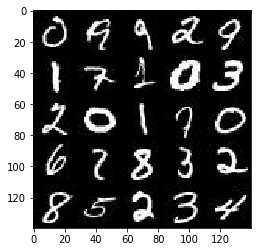

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

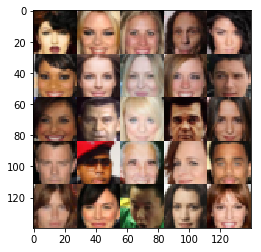

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_height, image_width, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    inputs_real = tf.placeholder(tf.float32, (None, image_height, image_width, image_channels), name='input_real')
    
    #print (image_channels)
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, None, name="learning_rate")


    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    # to do, make alpha global
    alpha = 0.2
    
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        #step 1: apply a convolution to the input with a leaky relu
        x1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same', kernel_initializer = tf.random_normal_initializer(stddev=0.02))
        x1 = tf.maximum(alpha * x1, x1)
        
        #step 2: add some layers
        # add batch normalization and a leaky relu each step
        x2 = tf.layers.conv2d(x1, 256, 5, strides=2, padding='same', kernel_initializer = tf.random_normal_initializer(stddev=0.02))
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d(x2, 512, 5, strides=2, padding='same', kernel_initializer = tf.random_normal_initializer(stddev=0.02))
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        
        #step 3: flatten the layer and calculate the outputs
        # To Do: parameterize the flat piece to make it more flexible.
        flat = tf.reshape(x3, (-1, 4*4*512))        
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits, name="out")

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2 
    
    reuse = not(is_train)
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=reuse):
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 256 , 5, strides=2, padding='same', kernel_initializer = tf.random_normal_initializer(stddev=0.02))
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 128 , 5, strides=2, padding='same', kernel_initializer = tf.random_normal_initializer(stddev=0.02))
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        # added an additional layer as per code review
        x4 = tf.layers.conv2d_transpose(x3, 64 , 5, strides=1, padding='same', kernel_initializer = tf.random_normal_initializer(stddev=0.02))
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
               
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 3, strides=1, padding='same')
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    smooth = 0.9
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    # apply layer smoothing
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)) * (1 - smooth))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    # added control dependencies as per code review
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    #saver = tf.train.Saver()
    
    #tf.reset_default_graph()

    _, image_height, image_width, image_dim = data_shape
    inputs_real, inputs_z, l_rate = model_inputs(image_height,image_width, image_dim ,z_dim)
    d_loss, g_loss = model_loss(inputs_real, inputs_z, image_dim)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images = batch_images * 2
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
               
                # Run optimizers
                
                #print (batch_images)
                #print (batch_z)
                #print (learning_rate)
       
                _ = sess.run(d_train_opt, feed_dict={inputs_real: batch_images, inputs_z: batch_z, l_rate: learning_rate})
                # added inputs real for the generator as we are now controlling dependencies
                _ = sess.run(g_train_opt, feed_dict={inputs_real: batch_images, inputs_z: batch_z, l_rate: learning_rate})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({inputs_z: batch_z, inputs_real: batch_images})
                    train_loss_g = g_loss.eval({inputs_z: batch_z})
                
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                if steps % 100 == 0:
                    show_generator_output(sess, 50, inputs_z, image_dim, data_image_mode)
                   

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.4389... Generator Loss: 1.2760
Epoch 1/2... Discriminator Loss: 0.0724... Generator Loss: 3.2471
Epoch 1/2... Discriminator Loss: 0.3338... Generator Loss: 1.6497
Epoch 1/2... Discriminator Loss: 2.5380... Generator Loss: 0.3326
Epoch 1/2... Discriminator Loss: 1.7396... Generator Loss: 0.9473
Epoch 1/2... Discriminator Loss: 1.7158... Generator Loss: 0.3586
Epoch 1/2... Discriminator Loss: 1.6778... Generator Loss: 1.0665
Epoch 1/2... Discriminator Loss: 1.4356... Generator Loss: 1.1900
Epoch 1/2... Discriminator Loss: 1.4446... Generator Loss: 1.0419
Epoch 1/2... Discriminator Loss: 1.2222... Generator Loss: 1.1376


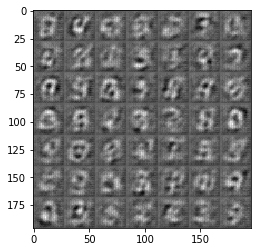

Epoch 1/2... Discriminator Loss: 1.5720... Generator Loss: 2.0797
Epoch 1/2... Discriminator Loss: 1.1231... Generator Loss: 1.3920
Epoch 1/2... Discriminator Loss: 1.2400... Generator Loss: 0.5701
Epoch 1/2... Discriminator Loss: 1.1955... Generator Loss: 1.1592
Epoch 1/2... Discriminator Loss: 1.1285... Generator Loss: 0.6320
Epoch 1/2... Discriminator Loss: 1.1825... Generator Loss: 0.5739
Epoch 1/2... Discriminator Loss: 0.9926... Generator Loss: 1.0644
Epoch 1/2... Discriminator Loss: 0.9838... Generator Loss: 1.1849
Epoch 1/2... Discriminator Loss: 0.9592... Generator Loss: 1.7937
Epoch 1/2... Discriminator Loss: 1.3727... Generator Loss: 2.7841


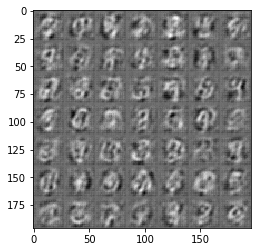

Epoch 1/2... Discriminator Loss: 0.8759... Generator Loss: 1.8567
Epoch 1/2... Discriminator Loss: 0.9111... Generator Loss: 0.7507
Epoch 1/2... Discriminator Loss: 0.8279... Generator Loss: 1.7688
Epoch 1/2... Discriminator Loss: 0.9469... Generator Loss: 1.6950
Epoch 1/2... Discriminator Loss: 0.9191... Generator Loss: 0.7731
Epoch 1/2... Discriminator Loss: 0.9043... Generator Loss: 1.5853
Epoch 1/2... Discriminator Loss: 0.7117... Generator Loss: 1.1456
Epoch 1/2... Discriminator Loss: 0.6967... Generator Loss: 1.1378
Epoch 1/2... Discriminator Loss: 1.1774... Generator Loss: 2.6081
Epoch 1/2... Discriminator Loss: 0.9357... Generator Loss: 1.1946


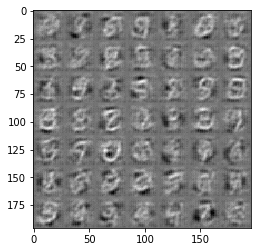

Epoch 1/2... Discriminator Loss: 0.9751... Generator Loss: 1.0993
Epoch 1/2... Discriminator Loss: 1.0808... Generator Loss: 1.5262
Epoch 1/2... Discriminator Loss: 1.3545... Generator Loss: 2.0581
Epoch 1/2... Discriminator Loss: 1.7051... Generator Loss: 0.2823
Epoch 1/2... Discriminator Loss: 0.9374... Generator Loss: 0.7659
Epoch 1/2... Discriminator Loss: 1.2960... Generator Loss: 0.4287
Epoch 1/2... Discriminator Loss: 1.0382... Generator Loss: 1.4187
Epoch 1/2... Discriminator Loss: 0.8497... Generator Loss: 1.4903
Epoch 1/2... Discriminator Loss: 1.0590... Generator Loss: 0.6171
Epoch 1/2... Discriminator Loss: 1.1345... Generator Loss: 1.5480


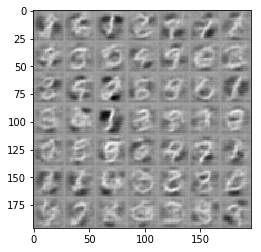

Epoch 1/2... Discriminator Loss: 1.1157... Generator Loss: 0.7221
Epoch 1/2... Discriminator Loss: 1.3033... Generator Loss: 1.8543
Epoch 1/2... Discriminator Loss: 0.9845... Generator Loss: 0.7816
Epoch 1/2... Discriminator Loss: 1.1770... Generator Loss: 0.6192
Epoch 1/2... Discriminator Loss: 0.8948... Generator Loss: 1.4843
Epoch 1/2... Discriminator Loss: 0.9645... Generator Loss: 1.2610
Epoch 1/2... Discriminator Loss: 1.5256... Generator Loss: 1.7317
Epoch 1/2... Discriminator Loss: 0.9439... Generator Loss: 1.4351
Epoch 1/2... Discriminator Loss: 1.0207... Generator Loss: 0.8648
Epoch 1/2... Discriminator Loss: 1.0196... Generator Loss: 0.7223


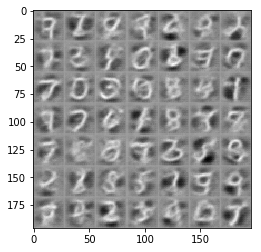

Epoch 1/2... Discriminator Loss: 0.9224... Generator Loss: 0.9681
Epoch 1/2... Discriminator Loss: 1.2739... Generator Loss: 1.9987
Epoch 1/2... Discriminator Loss: 0.8613... Generator Loss: 1.1914
Epoch 1/2... Discriminator Loss: 0.8487... Generator Loss: 1.2662
Epoch 1/2... Discriminator Loss: 1.0319... Generator Loss: 1.3218
Epoch 1/2... Discriminator Loss: 1.0290... Generator Loss: 1.1500
Epoch 1/2... Discriminator Loss: 1.0653... Generator Loss: 1.8377
Epoch 1/2... Discriminator Loss: 1.0298... Generator Loss: 0.6958
Epoch 1/2... Discriminator Loss: 1.3350... Generator Loss: 0.4333
Epoch 1/2... Discriminator Loss: 1.2063... Generator Loss: 0.5270


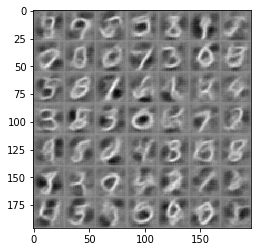

Epoch 1/2... Discriminator Loss: 0.9256... Generator Loss: 1.0084
Epoch 1/2... Discriminator Loss: 0.9751... Generator Loss: 0.7784
Epoch 1/2... Discriminator Loss: 1.1161... Generator Loss: 0.6107
Epoch 1/2... Discriminator Loss: 1.5026... Generator Loss: 0.3421
Epoch 1/2... Discriminator Loss: 1.2515... Generator Loss: 0.5347
Epoch 1/2... Discriminator Loss: 0.9425... Generator Loss: 1.4560
Epoch 1/2... Discriminator Loss: 0.9801... Generator Loss: 1.2222
Epoch 1/2... Discriminator Loss: 1.6488... Generator Loss: 0.2902
Epoch 1/2... Discriminator Loss: 1.1278... Generator Loss: 0.7990
Epoch 1/2... Discriminator Loss: 0.9927... Generator Loss: 1.3717


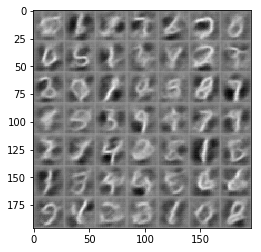

Epoch 1/2... Discriminator Loss: 0.9412... Generator Loss: 1.0455
Epoch 1/2... Discriminator Loss: 0.9131... Generator Loss: 1.2720
Epoch 1/2... Discriminator Loss: 0.9822... Generator Loss: 1.5898
Epoch 1/2... Discriminator Loss: 1.1154... Generator Loss: 1.1931
Epoch 1/2... Discriminator Loss: 0.9207... Generator Loss: 0.7989
Epoch 1/2... Discriminator Loss: 1.6020... Generator Loss: 0.3280
Epoch 1/2... Discriminator Loss: 0.9366... Generator Loss: 0.8063
Epoch 1/2... Discriminator Loss: 1.1603... Generator Loss: 0.7775
Epoch 1/2... Discriminator Loss: 0.8972... Generator Loss: 1.2063
Epoch 1/2... Discriminator Loss: 0.9462... Generator Loss: 0.9656


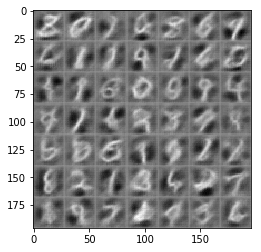

Epoch 1/2... Discriminator Loss: 1.0170... Generator Loss: 1.6019
Epoch 1/2... Discriminator Loss: 0.9088... Generator Loss: 0.7338
Epoch 1/2... Discriminator Loss: 0.7265... Generator Loss: 1.3846
Epoch 1/2... Discriminator Loss: 1.4411... Generator Loss: 0.4107
Epoch 1/2... Discriminator Loss: 0.8703... Generator Loss: 1.3465
Epoch 1/2... Discriminator Loss: 1.5571... Generator Loss: 0.4369
Epoch 1/2... Discriminator Loss: 0.9005... Generator Loss: 1.4299
Epoch 1/2... Discriminator Loss: 0.8049... Generator Loss: 1.3954
Epoch 1/2... Discriminator Loss: 1.2163... Generator Loss: 0.4892
Epoch 1/2... Discriminator Loss: 0.9869... Generator Loss: 0.8688


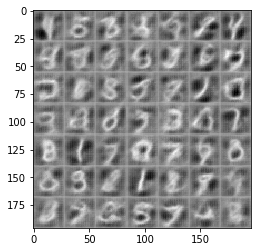

Epoch 1/2... Discriminator Loss: 1.0878... Generator Loss: 0.8253
Epoch 1/2... Discriminator Loss: 1.2254... Generator Loss: 0.5223
Epoch 1/2... Discriminator Loss: 1.3313... Generator Loss: 0.4542
Epoch 2/2... Discriminator Loss: 1.0799... Generator Loss: 0.5808
Epoch 2/2... Discriminator Loss: 1.5875... Generator Loss: 0.3034
Epoch 2/2... Discriminator Loss: 0.9900... Generator Loss: 0.8368
Epoch 2/2... Discriminator Loss: 0.8917... Generator Loss: 0.9165
Epoch 2/2... Discriminator Loss: 1.0509... Generator Loss: 1.5681
Epoch 2/2... Discriminator Loss: 0.9090... Generator Loss: 1.1550
Epoch 2/2... Discriminator Loss: 0.9073... Generator Loss: 1.2076


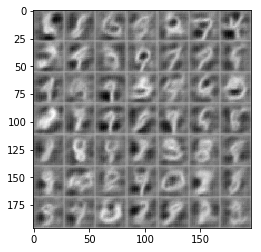

Epoch 2/2... Discriminator Loss: 0.9869... Generator Loss: 0.7082
Epoch 2/2... Discriminator Loss: 0.8810... Generator Loss: 1.0232
Epoch 2/2... Discriminator Loss: 1.4275... Generator Loss: 0.4068
Epoch 2/2... Discriminator Loss: 0.8562... Generator Loss: 1.1971
Epoch 2/2... Discriminator Loss: 1.0413... Generator Loss: 0.7075
Epoch 2/2... Discriminator Loss: 0.8933... Generator Loss: 1.3448
Epoch 2/2... Discriminator Loss: 2.1975... Generator Loss: 3.2060
Epoch 2/2... Discriminator Loss: 0.9826... Generator Loss: 0.7166
Epoch 2/2... Discriminator Loss: 0.9674... Generator Loss: 0.6822
Epoch 2/2... Discriminator Loss: 1.2379... Generator Loss: 0.5120


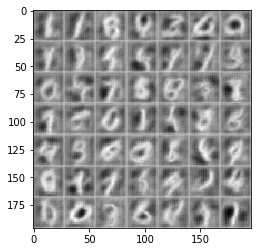

Epoch 2/2... Discriminator Loss: 1.0664... Generator Loss: 0.7811
Epoch 2/2... Discriminator Loss: 0.9522... Generator Loss: 1.1958
Epoch 2/2... Discriminator Loss: 0.9366... Generator Loss: 0.7940
Epoch 2/2... Discriminator Loss: 1.0220... Generator Loss: 0.7387
Epoch 2/2... Discriminator Loss: 0.8877... Generator Loss: 1.5262
Epoch 2/2... Discriminator Loss: 0.9619... Generator Loss: 0.6750
Epoch 2/2... Discriminator Loss: 1.0468... Generator Loss: 0.7132
Epoch 2/2... Discriminator Loss: 1.4848... Generator Loss: 0.3589
Epoch 2/2... Discriminator Loss: 1.6410... Generator Loss: 0.2980
Epoch 2/2... Discriminator Loss: 3.9913... Generator Loss: 5.0797


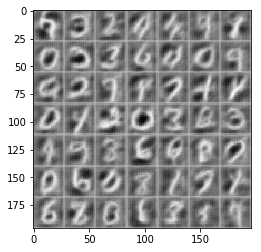

Epoch 2/2... Discriminator Loss: 1.0301... Generator Loss: 1.0776
Epoch 2/2... Discriminator Loss: 0.9777... Generator Loss: 0.8058
Epoch 2/2... Discriminator Loss: 1.0681... Generator Loss: 1.0354
Epoch 2/2... Discriminator Loss: 1.0534... Generator Loss: 0.8546
Epoch 2/2... Discriminator Loss: 0.9408... Generator Loss: 1.2747
Epoch 2/2... Discriminator Loss: 0.9086... Generator Loss: 0.8200
Epoch 2/2... Discriminator Loss: 0.8995... Generator Loss: 1.5594
Epoch 2/2... Discriminator Loss: 1.5129... Generator Loss: 0.3905
Epoch 2/2... Discriminator Loss: 1.1563... Generator Loss: 0.6860
Epoch 2/2... Discriminator Loss: 1.0295... Generator Loss: 0.7581


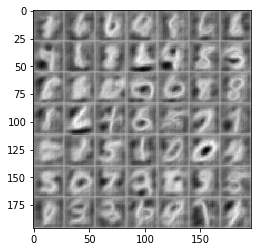

Epoch 2/2... Discriminator Loss: 0.9693... Generator Loss: 1.1440
Epoch 2/2... Discriminator Loss: 1.1677... Generator Loss: 0.8052
Epoch 2/2... Discriminator Loss: 0.9025... Generator Loss: 1.1204
Epoch 2/2... Discriminator Loss: 1.0360... Generator Loss: 0.7244
Epoch 2/2... Discriminator Loss: 1.1264... Generator Loss: 0.8900
Epoch 2/2... Discriminator Loss: 0.9667... Generator Loss: 1.2537
Epoch 2/2... Discriminator Loss: 1.3430... Generator Loss: 0.4737
Epoch 2/2... Discriminator Loss: 1.0394... Generator Loss: 0.7467
Epoch 2/2... Discriminator Loss: 1.3676... Generator Loss: 1.4719
Epoch 2/2... Discriminator Loss: 0.8456... Generator Loss: 1.1660


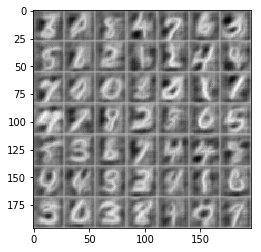

Epoch 2/2... Discriminator Loss: 0.9736... Generator Loss: 1.2665
Epoch 2/2... Discriminator Loss: 1.0151... Generator Loss: 0.8790
Epoch 2/2... Discriminator Loss: 1.0086... Generator Loss: 0.8015
Epoch 2/2... Discriminator Loss: 1.0405... Generator Loss: 1.3668
Epoch 2/2... Discriminator Loss: 1.0334... Generator Loss: 1.1405
Epoch 2/2... Discriminator Loss: 0.9490... Generator Loss: 1.4609
Epoch 2/2... Discriminator Loss: 1.0337... Generator Loss: 2.3683
Epoch 2/2... Discriminator Loss: 1.1029... Generator Loss: 1.4248
Epoch 2/2... Discriminator Loss: 0.9454... Generator Loss: 0.8638
Epoch 2/2... Discriminator Loss: 1.1393... Generator Loss: 0.5918


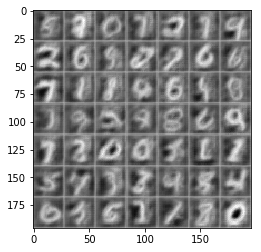

Epoch 2/2... Discriminator Loss: 1.4273... Generator Loss: 0.4730
Epoch 2/2... Discriminator Loss: 1.4359... Generator Loss: 0.4025
Epoch 2/2... Discriminator Loss: 1.3950... Generator Loss: 0.3953
Epoch 2/2... Discriminator Loss: 0.8789... Generator Loss: 1.0616
Epoch 2/2... Discriminator Loss: 1.1566... Generator Loss: 0.5443
Epoch 2/2... Discriminator Loss: 0.8993... Generator Loss: 1.4075
Epoch 2/2... Discriminator Loss: 1.0697... Generator Loss: 0.7483
Epoch 2/2... Discriminator Loss: 1.0406... Generator Loss: 0.7352
Epoch 2/2... Discriminator Loss: 0.8474... Generator Loss: 0.9470
Epoch 2/2... Discriminator Loss: 0.9884... Generator Loss: 0.7258


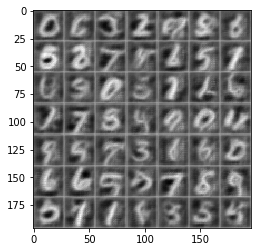

Epoch 2/2... Discriminator Loss: 2.0398... Generator Loss: 3.1641
Epoch 2/2... Discriminator Loss: 1.1996... Generator Loss: 0.5369
Epoch 2/2... Discriminator Loss: 0.8356... Generator Loss: 1.1225
Epoch 2/2... Discriminator Loss: 0.8646... Generator Loss: 1.0576
Epoch 2/2... Discriminator Loss: 1.2101... Generator Loss: 1.2806
Epoch 2/2... Discriminator Loss: 1.1133... Generator Loss: 1.2796
Epoch 2/2... Discriminator Loss: 0.9475... Generator Loss: 1.0769
Epoch 2/2... Discriminator Loss: 1.0378... Generator Loss: 0.9271
Epoch 2/2... Discriminator Loss: 1.0154... Generator Loss: 0.7095
Epoch 2/2... Discriminator Loss: 0.9091... Generator Loss: 0.8340


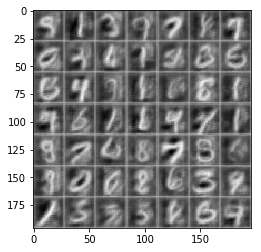

Epoch 2/2... Discriminator Loss: 1.0177... Generator Loss: 0.7025
Epoch 2/2... Discriminator Loss: 1.0140... Generator Loss: 0.7063
Epoch 2/2... Discriminator Loss: 1.6893... Generator Loss: 0.3079
Epoch 2/2... Discriminator Loss: 0.9911... Generator Loss: 1.1431
Epoch 2/2... Discriminator Loss: 0.9520... Generator Loss: 0.8477
Epoch 2/2... Discriminator Loss: 1.2274... Generator Loss: 1.4558
Epoch 2/2... Discriminator Loss: 1.6864... Generator Loss: 0.3137
Epoch 2/2... Discriminator Loss: 1.3376... Generator Loss: 0.4619
Epoch 2/2... Discriminator Loss: 1.2187... Generator Loss: 0.5785
Epoch 2/2... Discriminator Loss: 0.9868... Generator Loss: 0.9380


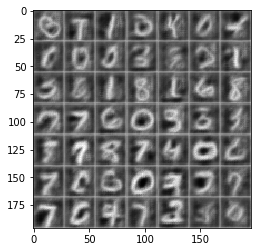

Epoch 2/2... Discriminator Loss: 0.8820... Generator Loss: 1.0428
Epoch 2/2... Discriminator Loss: 1.2255... Generator Loss: 0.5173
Epoch 2/2... Discriminator Loss: 1.0490... Generator Loss: 0.7166
Epoch 2/2... Discriminator Loss: 0.9007... Generator Loss: 0.8850
Epoch 2/2... Discriminator Loss: 1.0196... Generator Loss: 0.8972
Epoch 2/2... Discriminator Loss: 0.9529... Generator Loss: 0.7170
Epoch 2/2... Discriminator Loss: 0.8840... Generator Loss: 0.8878


In [18]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.0182... Generator Loss: 0.9853
Epoch 1/1... Discriminator Loss: 1.3098... Generator Loss: 43.0115
Epoch 1/1... Discriminator Loss: 0.8791... Generator Loss: 7.1169
Epoch 1/1... Discriminator Loss: 0.5883... Generator Loss: 1.8346
Epoch 1/1... Discriminator Loss: 0.4989... Generator Loss: 2.0417
Epoch 1/1... Discriminator Loss: 0.7189... Generator Loss: 1.0629
Epoch 1/1... Discriminator Loss: 0.4709... Generator Loss: 1.8209
Epoch 1/1... Discriminator Loss: 0.3977... Generator Loss: 2.9616
Epoch 1/1... Discriminator Loss: 0.4255... Generator Loss: 1.6462
Epoch 1/1... Discriminator Loss: 0.4539... Generator Loss: 1.3487


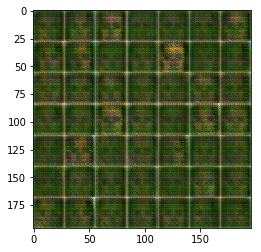

Epoch 1/1... Discriminator Loss: 0.3834... Generator Loss: 1.8244
Epoch 1/1... Discriminator Loss: 0.3494... Generator Loss: 2.7609
Epoch 1/1... Discriminator Loss: 0.4143... Generator Loss: 2.2903
Epoch 1/1... Discriminator Loss: 0.4384... Generator Loss: 1.6022
Epoch 1/1... Discriminator Loss: 0.3578... Generator Loss: 2.8076
Epoch 1/1... Discriminator Loss: 0.4557... Generator Loss: 3.1590
Epoch 1/1... Discriminator Loss: 0.4476... Generator Loss: 1.4966
Epoch 1/1... Discriminator Loss: 0.3962... Generator Loss: 1.8226
Epoch 1/1... Discriminator Loss: 0.3790... Generator Loss: 1.8884
Epoch 1/1... Discriminator Loss: 0.3691... Generator Loss: 1.9868


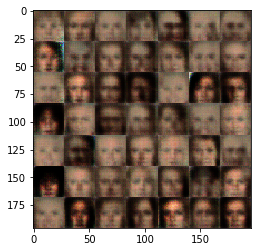

Epoch 1/1... Discriminator Loss: 0.3745... Generator Loss: 2.8969
Epoch 1/1... Discriminator Loss: 0.3582... Generator Loss: 2.3361
Epoch 1/1... Discriminator Loss: 0.3589... Generator Loss: 3.0488
Epoch 1/1... Discriminator Loss: 0.3414... Generator Loss: 2.4327
Epoch 1/1... Discriminator Loss: 0.3423... Generator Loss: 2.5927
Epoch 1/1... Discriminator Loss: 0.3432... Generator Loss: 2.0959
Epoch 1/1... Discriminator Loss: 0.3536... Generator Loss: 2.1099
Epoch 1/1... Discriminator Loss: 0.3298... Generator Loss: 2.5278
Epoch 1/1... Discriminator Loss: 0.3484... Generator Loss: 2.7157
Epoch 1/1... Discriminator Loss: 0.3630... Generator Loss: 2.1690


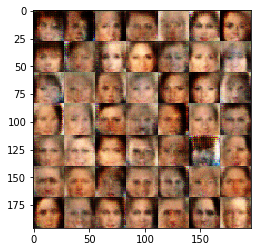

Epoch 1/1... Discriminator Loss: 0.3764... Generator Loss: 3.2009
Epoch 1/1... Discriminator Loss: 0.3628... Generator Loss: 3.0473
Epoch 1/1... Discriminator Loss: 0.3538... Generator Loss: 2.1686
Epoch 1/1... Discriminator Loss: 0.3610... Generator Loss: 2.2397
Epoch 1/1... Discriminator Loss: 0.3535... Generator Loss: 2.3455
Epoch 1/1... Discriminator Loss: 0.3460... Generator Loss: 2.2454
Epoch 1/1... Discriminator Loss: 0.3451... Generator Loss: 2.2114
Epoch 1/1... Discriminator Loss: 0.3390... Generator Loss: 2.3926
Epoch 1/1... Discriminator Loss: 0.3356... Generator Loss: 2.3074
Epoch 1/1... Discriminator Loss: 0.3418... Generator Loss: 2.2337


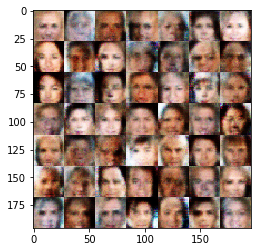

Epoch 1/1... Discriminator Loss: 0.3389... Generator Loss: 2.1132
Epoch 1/1... Discriminator Loss: 0.3695... Generator Loss: 1.9943
Epoch 1/1... Discriminator Loss: 0.3391... Generator Loss: 2.3191
Epoch 1/1... Discriminator Loss: 0.3372... Generator Loss: 2.5412
Epoch 1/1... Discriminator Loss: 0.3440... Generator Loss: 2.1722
Epoch 1/1... Discriminator Loss: 0.3522... Generator Loss: 2.0058
Epoch 1/1... Discriminator Loss: 0.3674... Generator Loss: 1.9990
Epoch 1/1... Discriminator Loss: 0.3439... Generator Loss: 2.1582
Epoch 1/1... Discriminator Loss: 0.3392... Generator Loss: 2.2458
Epoch 1/1... Discriminator Loss: 0.3762... Generator Loss: 1.9175


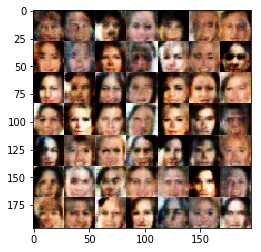

Epoch 1/1... Discriminator Loss: 0.3483... Generator Loss: 2.4381
Epoch 1/1... Discriminator Loss: 0.3551... Generator Loss: 2.0576
Epoch 1/1... Discriminator Loss: 0.3354... Generator Loss: 2.4922
Epoch 1/1... Discriminator Loss: 0.3523... Generator Loss: 2.2500
Epoch 1/1... Discriminator Loss: 0.3368... Generator Loss: 2.3096
Epoch 1/1... Discriminator Loss: 0.3546... Generator Loss: 1.9870
Epoch 1/1... Discriminator Loss: 0.3656... Generator Loss: 2.9378
Epoch 1/1... Discriminator Loss: 0.3358... Generator Loss: 2.2066
Epoch 1/1... Discriminator Loss: 0.3463... Generator Loss: 2.3475
Epoch 1/1... Discriminator Loss: 0.3526... Generator Loss: 2.3555


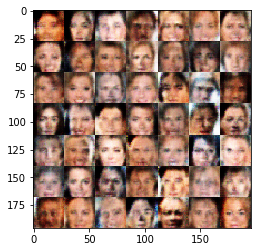

Epoch 1/1... Discriminator Loss: 0.3445... Generator Loss: 2.1401
Epoch 1/1... Discriminator Loss: 0.3355... Generator Loss: 2.2089
Epoch 1/1... Discriminator Loss: 0.3455... Generator Loss: 2.7551
Epoch 1/1... Discriminator Loss: 0.3524... Generator Loss: 2.7191
Epoch 1/1... Discriminator Loss: 0.3528... Generator Loss: 2.0187
Epoch 1/1... Discriminator Loss: 0.3430... Generator Loss: 2.0710
Epoch 1/1... Discriminator Loss: 0.3521... Generator Loss: 2.7373
Epoch 1/1... Discriminator Loss: 0.3334... Generator Loss: 2.5331
Epoch 1/1... Discriminator Loss: 0.3363... Generator Loss: 2.6138
Epoch 1/1... Discriminator Loss: 0.3455... Generator Loss: 2.8049


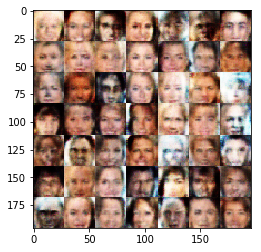

Epoch 1/1... Discriminator Loss: 0.3335... Generator Loss: 2.6221
Epoch 1/1... Discriminator Loss: 0.3493... Generator Loss: 3.0263
Epoch 1/1... Discriminator Loss: 0.3355... Generator Loss: 2.5971
Epoch 1/1... Discriminator Loss: 0.3456... Generator Loss: 2.0380
Epoch 1/1... Discriminator Loss: 0.3546... Generator Loss: 1.9696
Epoch 1/1... Discriminator Loss: 0.3410... Generator Loss: 2.0940
Epoch 1/1... Discriminator Loss: 0.3430... Generator Loss: 2.2307
Epoch 1/1... Discriminator Loss: 0.3571... Generator Loss: 2.5370
Epoch 1/1... Discriminator Loss: 0.3436... Generator Loss: 2.1001
Epoch 1/1... Discriminator Loss: 0.3356... Generator Loss: 2.3750


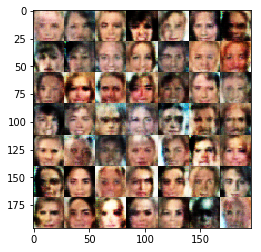

Epoch 1/1... Discriminator Loss: 0.3514... Generator Loss: 2.0099
Epoch 1/1... Discriminator Loss: 0.3625... Generator Loss: 1.8489
Epoch 1/1... Discriminator Loss: 0.3462... Generator Loss: 2.1101
Epoch 1/1... Discriminator Loss: 0.3409... Generator Loss: 2.4306
Epoch 1/1... Discriminator Loss: 0.3424... Generator Loss: 2.0963
Epoch 1/1... Discriminator Loss: 0.3457... Generator Loss: 2.2674
Epoch 1/1... Discriminator Loss: 0.3437... Generator Loss: 2.3609
Epoch 1/1... Discriminator Loss: 0.3312... Generator Loss: 2.3883
Epoch 1/1... Discriminator Loss: 0.3529... Generator Loss: 2.2897
Epoch 1/1... Discriminator Loss: 0.3526... Generator Loss: 1.8682


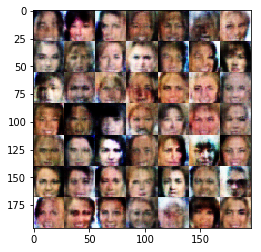

Epoch 1/1... Discriminator Loss: 0.3350... Generator Loss: 2.6985
Epoch 1/1... Discriminator Loss: 0.3411... Generator Loss: 2.6917
Epoch 1/1... Discriminator Loss: 0.3565... Generator Loss: 2.6874
Epoch 1/1... Discriminator Loss: 0.3710... Generator Loss: 3.0495
Epoch 1/1... Discriminator Loss: 0.3302... Generator Loss: 2.4541
Epoch 1/1... Discriminator Loss: 0.3571... Generator Loss: 2.9734
Epoch 1/1... Discriminator Loss: 0.3846... Generator Loss: 3.2284
Epoch 1/1... Discriminator Loss: 0.3727... Generator Loss: 2.9765
Epoch 1/1... Discriminator Loss: 0.3711... Generator Loss: 3.2350
Epoch 1/1... Discriminator Loss: 0.3469... Generator Loss: 2.6066


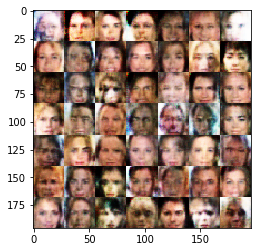

Epoch 1/1... Discriminator Loss: 0.3520... Generator Loss: 2.1296
Epoch 1/1... Discriminator Loss: 0.3541... Generator Loss: 2.2333
Epoch 1/1... Discriminator Loss: 0.3351... Generator Loss: 2.3654
Epoch 1/1... Discriminator Loss: 0.3383... Generator Loss: 2.5417
Epoch 1/1... Discriminator Loss: 0.3454... Generator Loss: 2.6930
Epoch 1/1... Discriminator Loss: 0.3412... Generator Loss: 2.2681
Epoch 1/1... Discriminator Loss: 0.3378... Generator Loss: 2.2083
Epoch 1/1... Discriminator Loss: 0.3467... Generator Loss: 2.2039
Epoch 1/1... Discriminator Loss: 0.3584... Generator Loss: 1.9277
Epoch 1/1... Discriminator Loss: 0.4005... Generator Loss: 2.8135


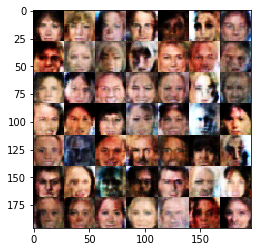

Epoch 1/1... Discriminator Loss: 0.3422... Generator Loss: 2.2213
Epoch 1/1... Discriminator Loss: 0.3589... Generator Loss: 2.0513
Epoch 1/1... Discriminator Loss: 0.3485... Generator Loss: 2.2125
Epoch 1/1... Discriminator Loss: 0.3750... Generator Loss: 3.1569
Epoch 1/1... Discriminator Loss: 0.3432... Generator Loss: 2.4056
Epoch 1/1... Discriminator Loss: 0.3488... Generator Loss: 2.7750
Epoch 1/1... Discriminator Loss: 0.3546... Generator Loss: 2.9699
Epoch 1/1... Discriminator Loss: 0.3398... Generator Loss: 2.6053
Epoch 1/1... Discriminator Loss: 0.3696... Generator Loss: 3.1102
Epoch 1/1... Discriminator Loss: 0.3451... Generator Loss: 2.5537


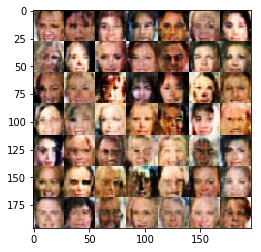

Epoch 1/1... Discriminator Loss: 0.3723... Generator Loss: 2.9490
Epoch 1/1... Discriminator Loss: 0.3455... Generator Loss: 2.8435
Epoch 1/1... Discriminator Loss: 0.3360... Generator Loss: 2.2306
Epoch 1/1... Discriminator Loss: 0.3309... Generator Loss: 2.2182
Epoch 1/1... Discriminator Loss: 0.3642... Generator Loss: 2.8017
Epoch 1/1... Discriminator Loss: 0.3399... Generator Loss: 1.9888
Epoch 1/1... Discriminator Loss: 0.3352... Generator Loss: 2.1880
Epoch 1/1... Discriminator Loss: 0.3358... Generator Loss: 2.5020
Epoch 1/1... Discriminator Loss: 0.3519... Generator Loss: 2.5092
Epoch 1/1... Discriminator Loss: 0.3292... Generator Loss: 2.2217


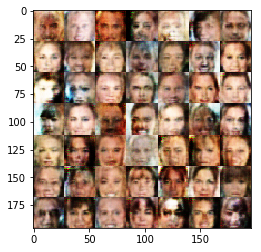

Epoch 1/1... Discriminator Loss: 0.3383... Generator Loss: 2.9310


In [ ]:
batch_size = 128
z_dim = 100
learning_rate = 0.0005
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.